In [2]:
import os
import pandas as pd
import seaborn as sns
from PIL import Image
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pydot
import graphviz
import tensorflow as tf

2024-11-25 14:49:43.245425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [101]:
root_dir = '/Users/vickieluo/downloads/roadsign/'

train_dir = root_dir + '/train/'
val_dir = root_dir + '/valid/'
# test_dir = root_dir + '/test/'
test_dir = root_dir + '/train/'

train_df = pd.read_csv(train_dir + '/_classes.csv')
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
val_df = pd.read_csv(val_dir + '/_classes.csv')
# test_df = pd.read_csv(test_dir + '/_classes.csv')

In [102]:
print(len(train_df))
print(len(val_df))

5673
1884


In [103]:
class_columns =  [" -Road narrows on right",
                " 50 mph speed limit",
                " Attention Please-",
                " Beware of children",
                " CYCLE ROUTE AHEAD WARNING",
                " Dangerous Left Curve Ahead",
                " Dangerous Rright Curve Ahead",
                " End of all speed and passing limits",
                " Give Way",
                " Go Straight or Turn Right",
                " Go straight or turn left",
                " Keep-Left",
                " Keep-Right",
                " Left Zig Zag Traffic",
                " No Entry",
                #" No_Over_Taking",
                " Overtaking by trucks is prohibited",
                " Pedestrian Crossing",
                " Round-About",
                " Slippery Road Ahead",
                #" Speed Limit 20 KMPh",
                #" Speed Limit 30 KMPh",
                " Stop_Sign",
                " Straight Ahead Only",
                " Traffic_signal",
                " Truck traffic is prohibited",
                " Turn left ahead",
                " Turn right ahead",
                " Uneven Road"]

In [104]:
# Turn filenames into paths

train_df['filename'] = train_dir + train_df['filename']
train_df = train_df.rename(columns={'filename': 'path'})

val_df['filename'] = val_dir + val_df['filename']
val_df = val_df.rename(columns={'filename': 'path'})

test_df['filename'] = test_dir + test_df['filename']
test_df = train_df.rename(columns={'filename': 'path'})

train_df.head()

,path,-Road narrows on right,50 mph speed limit,Attention Please-,Beware of children,CYCLE ROUTE AHEAD WARNING,Dangerous Left Curve Ahead,Dangerous Rright Curve Ahead,End of all speed and passing limits,Give Way,...,Slippery Road Ahead,Speed Limit 20 KMPh,Speed Limit 30 KMPh,Stop_Sign,Straight Ahead Only,Traffic_signal,Truck traffic is prohibited,Turn left ahead,Turn right ahead,Uneven Road
1554,/Users/vickieluo/downloads/roadsign//train/000...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4159,/Users/vickieluo/downloads/roadsign//train/000...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2057,/Users/vickieluo/downloads/roadsign//train/000...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5281,/Users/vickieluo/downloads/roadsign//train/000...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6946,/Users/vickieluo/downloads/roadsign//train/000...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
sums = []
for column in train_df.columns[1:]:
  print(column)
  sums.append(train_df[column].sum())
print(sums)

 -Road narrows on right
 50 mph speed limit
 Attention Please-
 Beware of children
 CYCLE ROUTE AHEAD WARNING
 Dangerous Left Curve Ahead
 Dangerous Rright Curve Ahead
 End of all speed and passing limits
 Give Way
 Go Straight or Turn Right
 Go straight or turn left
 Keep-Left
 Keep-Right
 Left Zig Zag Traffic
 No Entry
 No_Over_Taking
 Overtaking by trucks is prohibited
 Pedestrian Crossing
 Round-About
 Slippery Road Ahead
 Speed Limit 20 KMPh
 Speed Limit 30 KMPh
 Stop_Sign
 Straight Ahead Only
 Traffic_signal
 Truck traffic is prohibited
 Turn left ahead
 Turn right ahead
 Uneven Road
[175, 193, 364, 336, 173, 127, 222, 162, 341, 240, 134, 189, 263, 212, 263, 0, 146, 156, 240, 324, 18, 1, 99, 215, 26, 267, 269, 267, 251]


In [106]:
train_df = train_df[
    (train_df[' Speed Limit 20 KMPh'] != 1) &
    (train_df[' Speed Limit 30 KMPh'] != 1)
].copy()
train_df.drop([' Speed Limit 30 KMPh', ' No_Over_Taking', ' Speed Limit 20 KMPh'], axis=1, inplace=True) 


In [107]:
val_df = val_df[
    (val_df[' Speed Limit 20 KMPh'] != 1) &
    (val_df[' Speed Limit 30 KMPh'] != 1)
].copy()
val_df.drop([' Speed Limit 30 KMPh', ' No_Over_Taking', ' Speed Limit 20 KMPh'], axis=1, inplace=True) 


In [108]:
test_df = test_df[
    (test_df[' Speed Limit 20 KMPh'] != 1) &
    (test_df[' Speed Limit 30 KMPh'] != 1)
].copy()
test_df.drop([' Speed Limit 30 KMPh', ' No_Over_Taking', ' Speed Limit 20 KMPh'], axis=1, inplace=True) 


In [109]:
train_paths = train_df['path'].values
train_labels = train_df[class_columns].values

val_paths = val_df['path'].values
val_labels = val_df[class_columns].values

test_paths = test_df['path'].values
test_labels = test_df[class_columns].values

def load_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0
    return image, label

def preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0
    return image

X_test = np.array([preprocess_image(path).numpy() for path in test_paths])
y_test = np.array(test_labels)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_image).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_image).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_image).batch(32)

In [138]:
train_ds = train_ds.shuffle(buffer_size=32)

model = Sequential([
  #layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_columns))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [139]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 18)

In [140]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [early_stop]
)

Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 50s 254ms/step - accuracy: 0.4043 - loss: 2.1498 - val_accuracy: 0.8745 - val_loss: 0.4823
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 62s 303ms/step - accuracy: 0.9388 - loss: 0.2451 - val_accuracy: 0.9387 - val_loss: 0.2415
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - accuracy: 0.9787 - loss: 0.0930 - val_accuracy: 0.9574 - val_loss: 0.1879
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.9876 - loss: 0.0540 - val_accuracy: 0.9597 - val_loss: 0.1869
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - accuracy: 0.9890 - loss: 0.0449 - val_accuracy: 0.9750 - val_loss: 0.1332


In [141]:
model.evaluate(test_ds, batch_size=32)

177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9998 - loss: 0.0044


[0.004228880163282156, 0.9998231530189514]

In [143]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


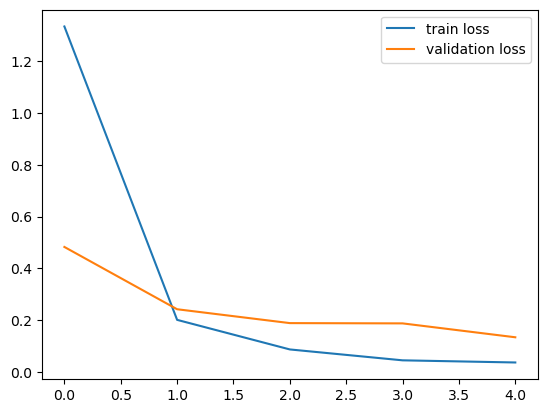

In [144]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


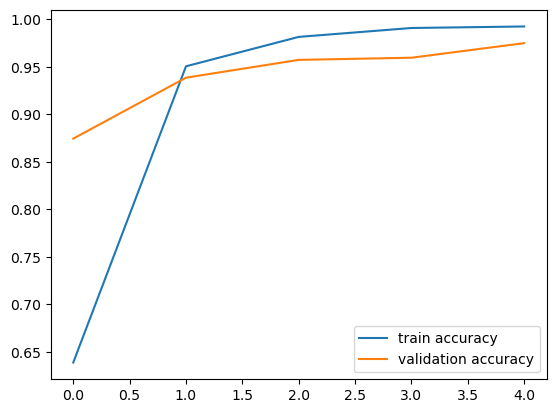

In [145]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [134]:
metrics[['accuracy']].plot()

KeyError: "None of [Index(['accuracy'], dtype='object')] are in the [columns]"

In [ ]:
predictions = model.predict(X_test)
predictions_classes = np.argmax(predictions, axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(confusion_matrix(y_true, predictions_classes))
img_path = '/Users/vickieluo/downloads/roadsign/test/00001_00060_00025_png_jpg.rf.000c35625c7010cffe4f4cbc61d51afb.jpg'

177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step
[[175   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0 193   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0 364   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 336   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0 173   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 127   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 341   0   0   0   0   0   0   0   0   0
    0   0  

Visualizing feature maps for layer 1


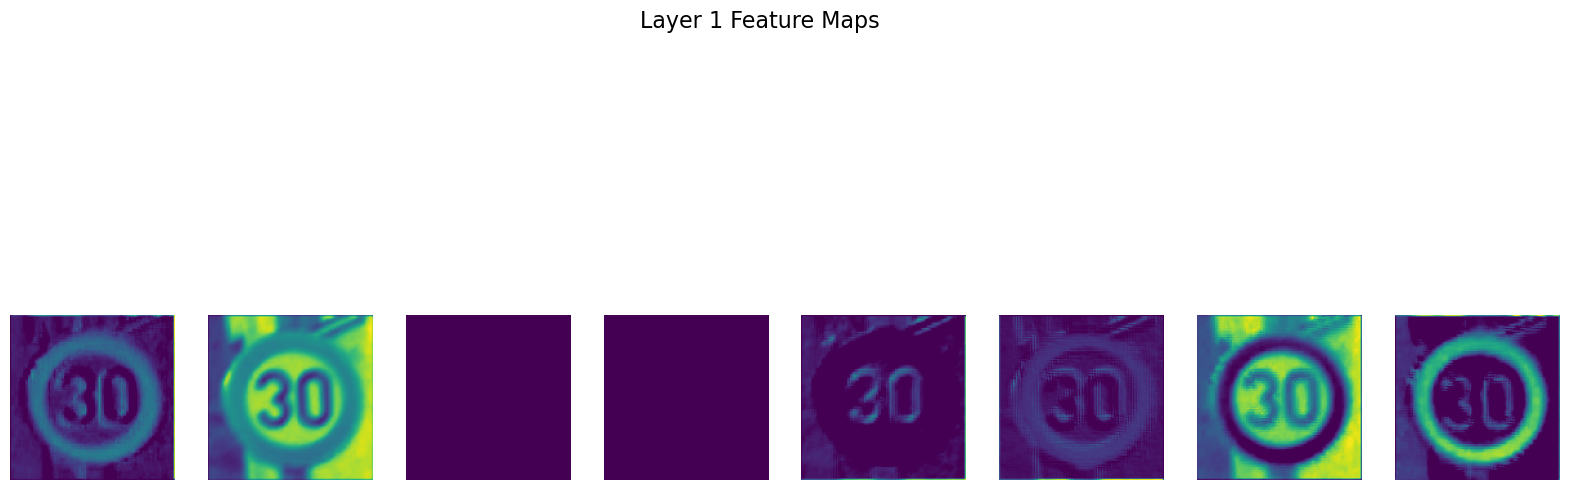

Visualizing feature maps for layer 2


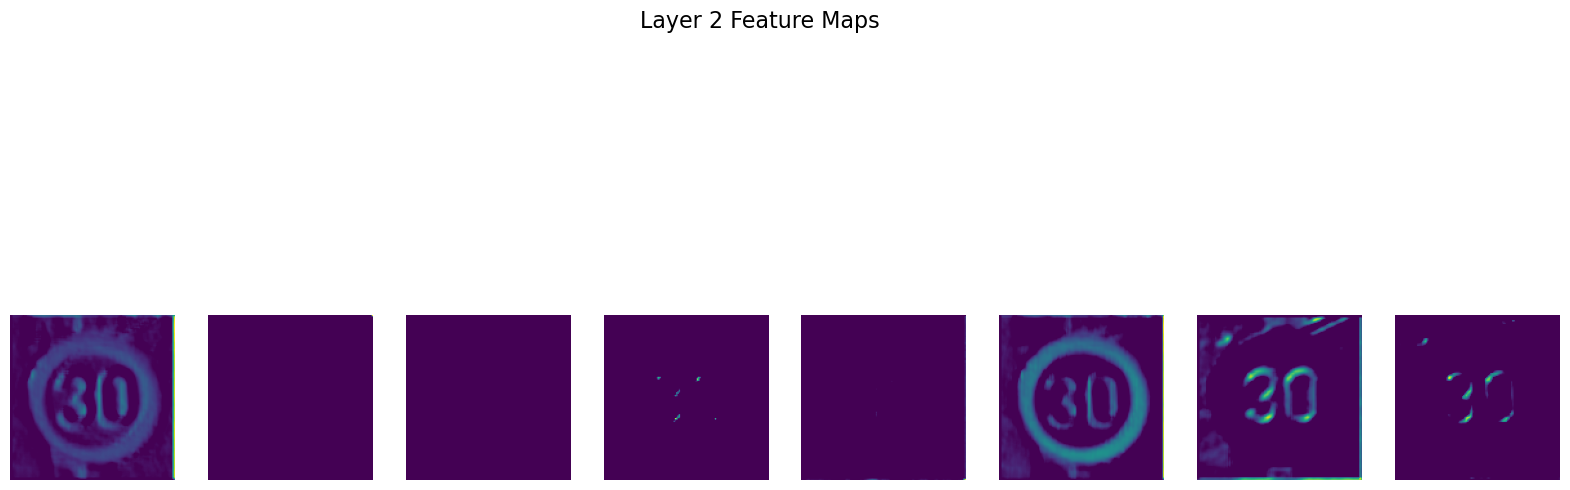

In [ ]:
#show feature maps
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D
img_path = '/Users/vickieluo/downloads/roadsign/test/00001_00060_00025_png_jpg.rf.000c35625c7010cffe4f4cbc61d51afb.jpg'
  # Replace with your image path
img = load_img(img_path, target_size=(128, 128))  
img_array = img_to_array(img) / 255.0  
img_array = np.expand_dims(img_array, axis=0) 

intermediate_outputs = []

# Pass the input through each layer sequentially
current_input = img_array  
for layer in model.layers:
    if isinstance(layer, Conv2D): 
        current_input = layer(current_input)  
        intermediate_outputs.append(current_input) 


# Step 3: Visualize feature maps
def visualize_feature_maps(feature_maps):
    for layer_index, feature_map in enumerate(feature_maps):
        print(f"Visualizing feature maps for layer {layer_index + 1}")

        num_filters = feature_map.shape[-1]

        fig, axes = plt.subplots(1, min(8, num_filters), figsize=(20, 8))
        fig.suptitle(f"Layer {layer_index + 1} Feature Maps", fontsize=16)

        for i in range(min(8, num_filters)):  
            ax = axes[i]
            ax.imshow(feature_map[0, :, :, i], cmap='viridis') 
            ax.axis('off')
        plt.show()

# Step 4: Call the visualization function
visualize_feature_maps(intermediate_outputs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step


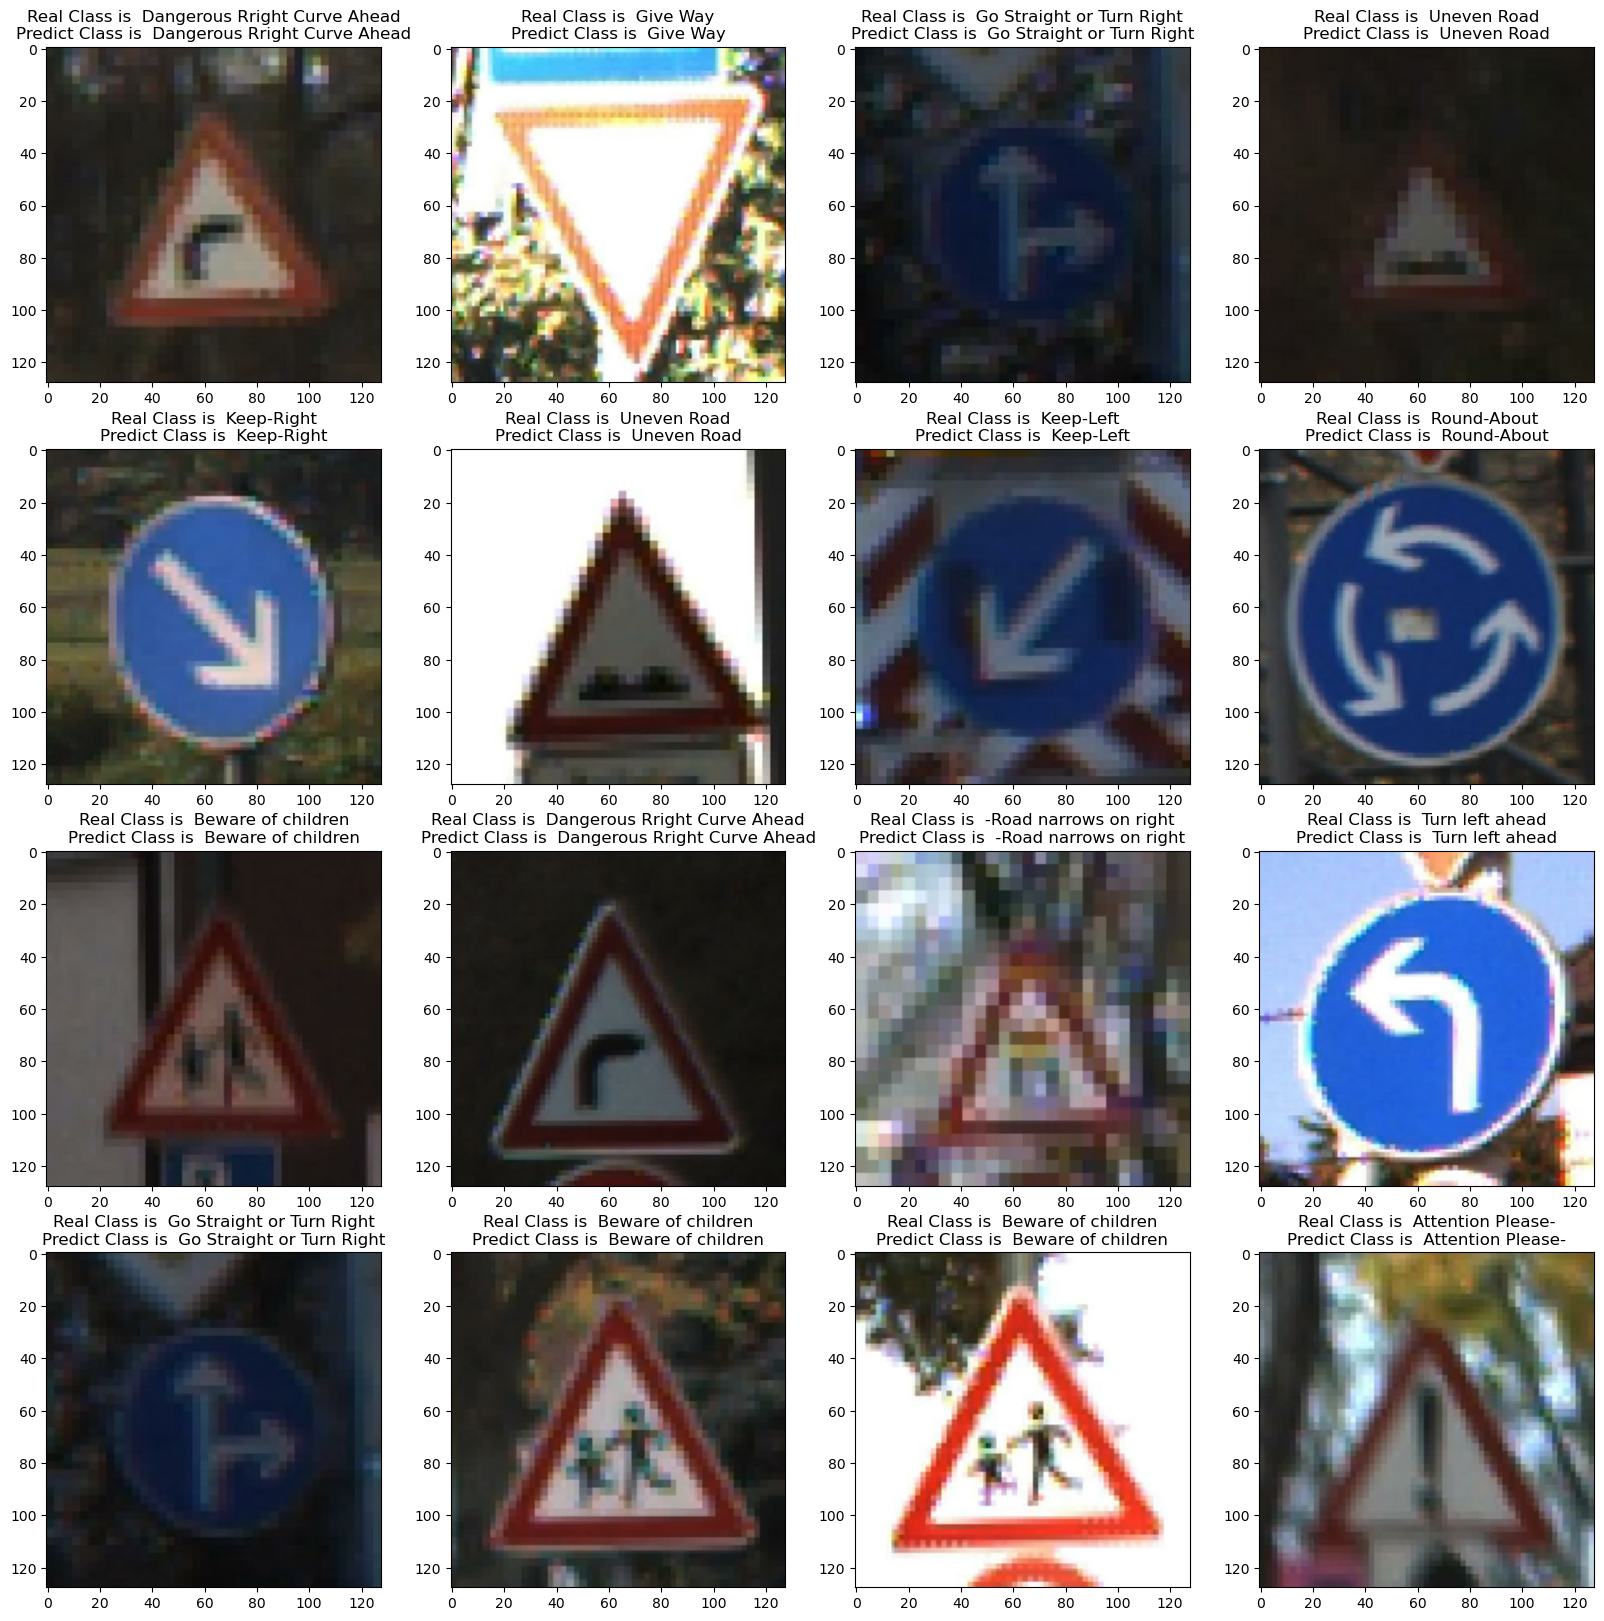

In [122]:
predictions = model.predict(X_test)
X_test_reshape = X_test.reshape(X_test.shape[0], 128, 128, 3)

fig, axis = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    if len(X_test_reshape.shape) == 3: 
        ax.imshow(X_test_reshape[i], cmap='gray')
    elif len(X_test_reshape.shape) == 4: 
        ax.imshow(X_test_reshape[i])
    ax.set(title = f"Real Class is {class_columns[y_test[i].argmax()]}\nPredict Class is {class_columns[predictions[i].argmax()]}");
plt.show()